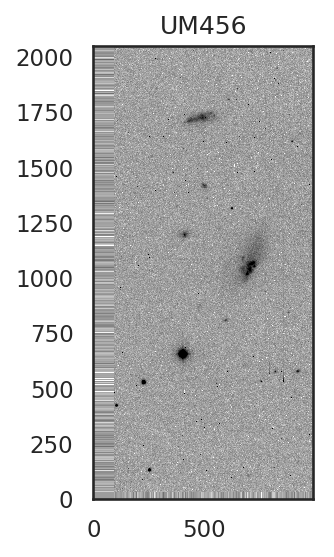

In [33]:
#Effective Point Spread Function (ePSF) - Astropy
import numpy as np
import matplotlib.pyplot as plt
#from astropy.modeling import models, fitting
from astropy.visualization import simple_norm
from astropy.io import fits
2
from astropy.table import Table
%matplotlib inline

# Load the data and find center of PSF
filename = 'UM456'

image_full='/home/JackS/Documentos/python/galaxies/'+filename+'_full.fits'
image = fits.getdata(image_full)

norm = simple_norm(image, 'sqrt', percent=99.7)

fig = plt.figure(dpi=150, edgecolor='white')
ax = fig.add_subplot(111)
plt.title(filename)
plt.imshow(image,norm=norm, origin='lower', cmap='gray_r')

In [34]:
#Manual coord stars
from astropy.table import Table
coord_star = np.array([[226.50,526.50], [626.50,1314.50] , [254.50,130.50]]) #Estrelas, não saturadas, p/ construção do ePSF
stars_tbl =  Table(names=['x', 'y'], data=coord_star)
print('Table manual coord stars')
print(stars_tbl)

Table manual coord stars
  x     y   
----- ------
226.5  526.5
626.5 1314.5
254.5  130.5


In [3]:
#Detect stars (Optional)
from photutils import find_peaks
import photutils

threshold = photutils.detect_threshold(image, snr=5.0, background=None, error=None)  #OUTRA IDEIA É USAR Thre... como 300
peaks_tbl = find_peaks(image, threshold,box_size=11,border_width=200)  # threshold, quanto maior menos estrelas fracas
#peaks_tbl = find_peaks(image, threshold = 100.,box_size=11,border_width=10)
peaks_tbl['peak_value'].info.format = '%.7g'  # for consistent table output 
print('Sorce detected') 
print(peaks_tbl)

#Table Positions
from astropy.table import Table
size = 41 #Size Frame star
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']
y = peaks_tbl['y_peak']
mask = ((x > hsize) & (x < (image.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (image.shape[0] -1 - hsize)))
stars_tbl = Table()
stars_tbl['x'] = x[mask]  
stars_tbl['y'] = y[mask] 
print('Table coord find stars')
print(stars_tbl)

Sorce detected
x_peak y_peak peak_value
------ ------ ----------
   484    200   3.201476
   282    203   2.049078
   338    210   22.15851
   386    236   1.397449
   227    242   2.184629
   293    249    1.30416
   634    284   2.747303
   403    286   1.706874
   390    288   1.500913
   595    293   2.785999
   ...    ...        ...
   423   1757   2.254574
   671   1771   1.605796
   785   1771   2.142648
   700   1783   7.418237
   645   1806   3.125458
   613   1807   0.608063
   666   1811   2.826431
   581   1825   2.641577
   531   1831   2.638276
   428   1840   5.459251
   366   1842   1.017033
Length = 296 rows
Table coord find stars
 x   y  
--- ----
484  200
282  203
338  210
386  236
227  242
293  249
634  284
403  286
390  288
595  293
...  ...
423 1757
671 1771
785 1771
700 1783
645 1806
613 1807
666 1811
581 1825
531 1831
428 1840
366 1842
Length = 296 rows


In [35]:
#Subtraindo o céu global - se o céu já tiver subtraido ignorar
from astropy.stats import sigma_clipped_stats
mean_val, median_val, std_val = sigma_clipped_stats(image, sigma=2.)  
image -= median_val  

IndexError: list index out of range

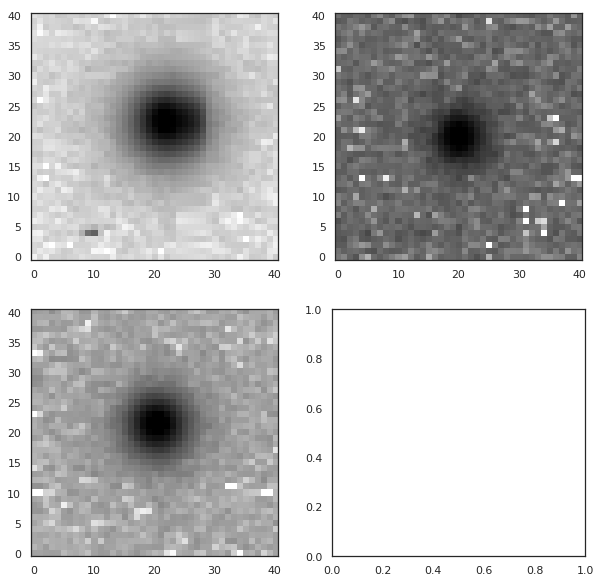

In [36]:
#Extract Stars
from astropy.nddata import NDData
from photutils.psf import extract_stars
nddata = NDData(data=image)     #1° - criar um NDData
stars = extract_stars(nddata, stars_tbl, size=41) #2° - Extrair estrela
#centroid_func = NDData(stars_tbl)
#print(centroid_func)

size_table = len(stars_tbl)
nrows = int((size_table)**0.5)
ncols = int((size_table)**0.5)
if nrows <=1:
    nrows , ncols = 2 ,2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10),squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='gray_r')

[[-2.78222563e-06 -4.86447228e-06 -2.34081675e-04 ... -1.66238589e-06
   7.66979255e-07  0.00000000e+00]
 [ 2.20949980e-06 -1.26379277e-04 -4.93706075e-04 ... -5.03746361e-08
   2.37390172e-08  0.00000000e+00]
 [-5.64026103e-06 -2.97627097e-04 -3.79544537e-04 ...  1.14930818e-06
  -5.27356376e-07  0.00000000e+00]
 ...
 [ 6.61707343e-06  1.39098222e-04  5.92550477e-05 ... -1.59124876e-05
   7.39041190e-06  0.00000000e+00]
 [-4.33878685e-06 -2.44848355e-05 -6.42229490e-05 ...  1.77436131e-05
  -8.19565490e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


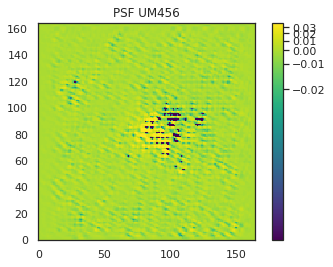

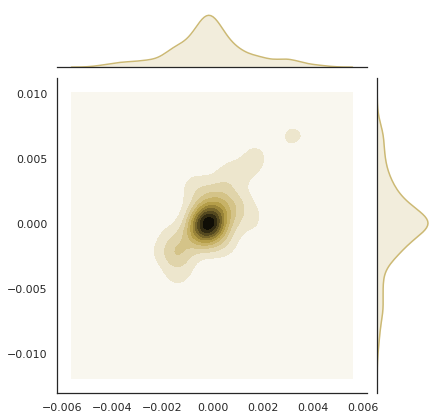

In [37]:
#Criando o ePSF
from photutils import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=4, maxiters=3,
                           progress_bar=False)  
epsf, fitted_stars = epsf_builder(stars)
print(epsf.data)

norm = simple_norm(epsf.data, 'log', percent=99.)
plt.title('PSF '+filename)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

import seaborn as sns
sns.set(style="white", color_codes=True)
g = (sns.jointplot(epsf.data[0], epsf.data[1], kind="kde", color="y"))


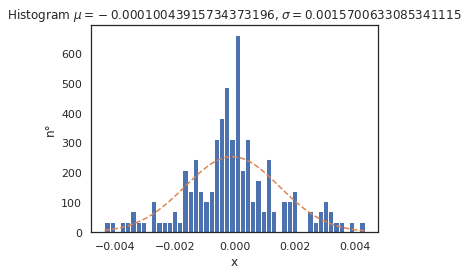

In [38]:
mean_val, median_val, std_val = sigma_clipped_stats(epsf.data[0], sigma=3.)
mu = mean_val  # mean of distribution
sigma = std_val # standard deviation of distribution
num_bins = 50

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(epsf.data[0], num_bins, density=1)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.set_xlabel('x')
ax.set_ylabel('n°')
ax.set_title(r'Histogram $\mu=%s$, $\sigma=%s$'%(mu,sigma))

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

In [89]:
# Compute FWHM(x,y) using 2D Gaussian fit, min-square optimization
# Optimization fits 2D gaussian: center, sigmas, baseline and amplitude
# works best if there is only one blob and it is close to the image center.
# author: Nikita Vladimirov @nvladimus (2018).
# based on code example: https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m

import scipy.optimize as opt

def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta,offset):
    (x, y) = xdata_tuple                                                        
    xo = float(xo)                                                              
    yo = float(yo)                                                              
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)   
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)    
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)   
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)         
                        + c*((y-yo)**2)))                                   
    return g.ravel()

def getFWHM_GaussianFitScaledAmp(img):
    """Get FWHM(x,y) of a blob by 2D gaussian fitting
    Parameter:
        img - image as numpy array
    Returns: 
        FWHMs in pixels, along x and y axes.
    """
    x = np.linspace(0, img.shape[1], img.shape[1])
    y = np.linspace(0, img.shape[0], img.shape[0])
    x, y = np.meshgrid(x, y)
    #Parameters: xpos, ypos, sigmaX, sigmaY, amp, baseline
    initial_guess = (img.shape[1]/2,img.shape[0]/2,10,10,1,0)
    # subtract background and rescale image into [0,1], with floor clipping
    bg = np.percentile(img,5)
    img_scaled = np.clip((img - bg) / (img.max() - bg),0,1)
    popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), 
                               img_scaled.ravel(), p0=initial_guess,
                               bounds = ((img.shape[1]*0.4, img.shape[0]*0.4, 1, 1, 0.5, -0.1), 
                                         (img.shape[1]*0.6, img.shape[0]*0.6, img.shape[1]/2, 
                                          img.shape[0]/2, 1.5, 0.5)))
    xcenter, ycenter, sigmaX, sigmaY, amp, offset = popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]
    FWHM_x = np.abs(4*sigmaX*np.sqrt(-0.5*np.log(0.5)))
    FWHM_y = np.abs(4*sigmaY*np.sqrt(-0.5*np.log(0.5)))
    return (FWHM_x, FWHM_y)

#calling example: img is your image
(FWHM_x, FWHM_y) = getFWHM_GaussianFitScaledAmp(epsf.data) 

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

5
